In [13]:
import sys
from typing import List, Dict, Tuple
from data_tools import task_map, row_operations
from utils import persistence as ps
from urllib3.response import HTTPResponse
from pandas import DataFrame, read_csv, concat, Grouper, melt, merge_asof, Timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, cpu_count
from error_handling import errors
from scipy import stats
from geo_merger import geo_merge, EXT
from numpy import array
from time import sleep
from functools import reduce

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
RGTRANSIT_BUCKET: str = 'rg-transit'
RGFARES_BUCKET: str = 'rg-tsfare'
RGGCABS_BUCKET: str = 'rg-gcabs'
RGYCABS_BUCKET: str = 'rg-ycabs'
RGTRAFFIC_BUCKET: str = 'rg-traffic'
REFBASE_BUCKET: str = 'ref-base'
GEOMERGED_PATH: str = 'geo-merged/'
PLOTS_BUCKET: str = 'plots'

MIN_INVW= 1 / 9.5
MAX_INVW = 1 / 0.5
RELPLOT_SZ_MULT = 1.5

BASE_COLOR='#34495E'
COLOR1='#E74C3C'
COLOR2='#2ECC71'

In [16]:
station_complex_map: Dict[str, str] = {
                                'BOWERY': 'BOWERY STREET-DELANCEY ST',
                                'WALL ST': 'WALL STREET',
                                'COURT SQ': 'COURT SQ',
                                '86 ST': '86TH STREET-4TH AVENUE',
                                'SOUTH FERRY': 'WHITEHALL STREET'
                              }
station_map: Dict[str, int] = {
                                'BOWERY': 103,
                                'WALL ST': 413,
                                'COURT SQ': 274,
                                '86 ST': 397,
                                'SOUTH FERRY': 330
                              }
weekday_map: Dict[int, str] = {
                                0 : 'Monday',
                                1 : 'Tuesday',
                                2 : 'Wednesday',
                                3 : 'Thursday',
                                4 : 'Friday',
                                5 : 'Saturday',
                                6 : 'Sunday'
                              }


In [17]:
def get_axis_range(df: DataFrame, col: str) -> Tuple:
    return df[col].min(), df[col].max()


def create_plot(df1: DataFrame, varcol1: str, label1: str, df2: DataFrame, varcol2: str, label2: str,
                ax: plt.Axes.axis, weighted: bool=False, weight_col: str=None,
                multiplot: bool=False, multicol: str=None, station: str='', weekday: int=None):
    sns.lineplot(data=df1[varcol1], ax=ax, color=BASE_COLOR, label=label1)
    ax1 = ax.twinx()
    if weighted:
        df2[varcol2] = df2[varcol2] / (RELPLOT_SZ_MULT * df2[weight_col])
    df2 = row_operations.drop_outliers(df=df2, col=varcol2)

    if multiplot:
        df2 = df2.reset_index()
        g = sns.lineplot(x='date', y=varcol2, estimator=None, ax=ax1, hue=multicol, data=df2, linewidth=.7, legend=False)
    else:
        g = sns.lineplot(data=df2[varcol2], ax=ax1, color=COLOR1, label=label2)
    ax.set_ylabel(label1)
    ax1.set_ylabel(label2)

    #box = g.get_position()
    #g.set_position([box.x0, box.y0, box.width * .85, box.height])
    #g.legend(loc='upper right', bbox_to_anchor=(1.05, 1), ncol=1)
    ax.set_title(station+' '+label1 + ' vs ' + label2+ ' for '+weekday_map[weekday])
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=.0)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, handletextpad=0, columnspacing=1, loc='upper left', ncol=2, frameon=True)
    return


def create_reg_plot(df: DataFrame, varcol1: str, label1: str, varcol2: str, label2: str,
                    ax: plt.Axes.axis, weighted: bool=False, weight_col: str=None,
                    multiplot: bool=False, multicol: str=None):
    if weighted:
        df[varcol2] = df[varcol2] / (RELPLOT_SZ_MULT * df[weight_col])
    df = row_operations.drop_outliers(df=df, col=varcol2)
    if multiplot:
        g = sns.scatterplot(x=varcol1, y=varcol2, data=df, ax=ax, hue=multicol, s=10)
    else:
        g = sns.regplot(x=varcol1, y=varcol2, data=df, ax=ax, color=COLOR1, scatter_kws={'s':10}, line_kws={'linewidth':.8})
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    return


def create_rel_plot(df: DataFrame, varcol1: str, label1: str, varcol2: str, label2: str, ax: plt.Axes.axis, weighted: bool=False, weight_col: str=None):
    if weighted:
        df[varcol2] = df[varcol2] / (RELPLOT_SZ_MULT * df[weight_col])
    df = row_operations.drop_outliers(df=df, col=varcol2)
    sns.relplot(x=varcol1, y=varcol2, data=df, ax=ax, color=COLOR1, scatter_kws={'s':10})
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    #ax.set_title(label1 + ' vs ' + label2)
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=.0)
    return

In [18]:
def plot_for_station(task: str, freq: str, filterby: str, filterval: str, station: str, sub_task: str, geomerged_cabs_df: DataFrame=None, geomerged_traffic_df: DataFrame=None, gas_df: DataFrame=None, weather_df: DataFrame=None):
    import matplotlib.pyplot as plt
    try:
        #freq: str = task_map.task_type_map[task]['freq']
        range: List[str] = task_map.task_type_map[task]['range']
        start_date: str = range[0]
        end_date: str = range[1]
        # determine filename of transit data for
        # the current station in the rg-transit bucket
        # replace '/' in station with ' '
        file_path: str = freq+'/'+filterby+filterval+'/'
        ts_filename: str = file_path+station.replace('/', ' ').upper()

        # read transit data for station (rg-transit bucket)
        filestream = ps.get_file_stream(bucket=RGTRANSIT_BUCKET, filename=ts_filename)
        ts_datecols = ['datetime']
        dtypes = {
                 'delex': 'int64',
                 'delent': 'int64'
                }
        transit_df = read_csv(filestream, usecols=ts_datecols + list(dtypes.keys()),
                                         parse_dates=ts_datecols,
                                         date_parser=row_operations.parse_rg_dt,
                                         encoding='utf-8', dtype=dtypes)
        transit_df = transit_df.set_index('datetime').resample(freq).sum().loc[start_date: end_date]
        #print(transit_df.head())

        # read fares data for station complex using station_complex_map dictionary
        fares_file_path: str = freq+'/'
        fares_filename: str = fares_file_path+station_complex_map[station.upper()]
        filestream = ps.get_file_stream(bucket=RGFARES_BUCKET, filename=fares_filename)
        fares_datecols = ['date']
        fares_dtypes = {
            'FF': 'int64',
            'SEN/DIS': 'int64',
            #'7-D AFAS UNL': 'int64',
            #'30-D AFAS/RMF UNL': 'int64',
            #'JOINT RR TKT': 'int64',
            '7-D UNL': 'int64',
            '30-D UNL': 'int64',
            #'14-D RFM UNL': 'int64',
            #'1-D UNL': 'int64',
            #'14-D UNL': 'int64',
            #'7D-XBUS PASS': 'int64',
            #'TCMC': 'int64',
            #'RF 2 TRIP': 'int64',
            #'RR UNL NO TRADE': 'int64',
            #'TCMC ANNUAL MC': 'int64',
            #'MR EZPAY EXP': 'int64',
            #'MR EZPAY UNL': 'int64',
            #'PATH 2-T': 'int64',
            #'AIRTRAIN FF': 'int64',
            #'AIRTRAIN 30-D': 'int64',
            #'AIRTRAIN 10-T': 'int64',
            #'AIRTRAIN MTHLY': 'int64',
            'STUDENTS': 'int64'
        }
        fares_df = read_csv(filestream, usecols=fares_datecols + list(fares_dtypes.keys()),
                                         parse_dates=fares_datecols,
                                         date_parser=row_operations.parse_rg_dt,
                                         encoding='utf-8', dtype=fares_dtypes)
        # fares data is for one week starting saturday and is dated as of the starting saturday.
        # shift dates from saturday to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
        # shift by one day + one week to move to end of time period
        td: Timedelta = Timedelta(8, unit='d')
        fares_df[fares_datecols[0]] = fares_df[fares_datecols[0]] + td
        fares_df = melt(fares_df, id_vars=fares_datecols, var_name='fare_type', value_name='total_users')
        fares_df = fares_df.groupby(fares_datecols+['fare_type']).sum()
        fares_df = fares_df.reset_index().set_index(fares_datecols).sort_index().loc[start_date: end_date]

        # create plots
        tmp_filepath: str = '/tmp/'
        sns.set(font_scale=.65, rc={'lines.linewidth':1})
        sns.set_style('dark')
        plt.close('all')
        fig, axes = plt.subplots(nrows=2, ncols=2, clear=True, figsize=(18, 6))
        plt.subplots_adjust(wspace=.4, hspace=.2)
        ts_col1 = 'delex'
        ts_col2 = 'delent'
        ts_label = 'transit '

        if sub_task in ['gcabs', 'ycabs']:
            # read data from other in buckets
            cabs_datecols = ['dodatetime']

            # determine relevant cabs files
            # by finding dolocationids corresponding
            # to current station from ref-base geomerged df
            dolocationids = geomerged_cabs_df.loc[geomerged_cabs_df.tsstation == station][['locationid', 'weight']]

            cabs_dtypes = {
                    'dolocationid': 'int64',
                    'passengers': 'int64',
                    'distance': 'float64'
                }

            if sub_task == 'gcabs':
                gcabs_df: DataFrame
                gcabs_df = concat([read_csv(ps.get_file_stream(bucket=RGGCABS_BUCKET, filename=file_path+str(locationid)),
                                            header=0,
                                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                                            parse_dates=cabs_datecols,
                                            encoding='utf-8', dtype=cabs_dtypes)
                                   for locationid in dolocationids['locationid']
                                   if str(locationid) in ps.get_all_filenames(bucket=RGGCABS_BUCKET, path=file_path)],
                                   ignore_index=True)
                gcabs_df = gcabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left', copy=False).\
                    drop(columns=['dolocationid', 'locationid']).drop_duplicates()

                gcabs_df = gcabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
                                                                                                                'distance': 'sum',
                                                                                                                 'weight': 'first'}).loc[start_date: end_date]
                #print(gcabs_df.head())

                # plots for cabs
                if dolocationids.size > 0 and gcabs_df.size > 0:
                    gcabs_label = 'green cabs '
                    gcabs_col = 'passengers'
                    create_plot(df1=transit_df,
                                varcol1=ts_col1,
                                label1=ts_label + 'exits',
                                df2=gcabs_df,
                                varcol2=gcabs_col,
                                label2=gcabs_label + gcabs_col,
                                ax=axes[0, 0],
                                weighted=True,
                                weight_col='weight',
                                station=station,
                                weekday=int(filterval))

                    create_plot(df1=transit_df,
                                varcol1=ts_col2,
                                label1=ts_label + 'entries',
                                df2=gcabs_df,
                                varcol2=gcabs_col,
                                label2=gcabs_label + gcabs_col,
                                ax=axes[0, 1],
                                weighted=True,
                                weight_col='weight',
                                station=station,
                                weekday=int(filterval))

                    df = transit_df.join(gcabs_df, how='outer') \
                        [[ts_col1, ts_col2, gcabs_col, 'weight']]
                    create_reg_plot(df=df,
                                    varcol1=ts_col1,
                                    label1=ts_label + 'exits',
                                    varcol2=gcabs_col,
                                    label2=gcabs_label + gcabs_col,
                                    ax=axes[1, 0],
                                    weighted=True,
                                    weight_col='weight')
                    create_reg_plot(df=df,
                                    varcol1=ts_col2,
                                    label1=ts_label + 'entries',
                                    varcol2=gcabs_col,
                                    label2=gcabs_label + gcabs_col,
                                    ax=axes[1, 1],
                                    weighted=True,
                                    weight_col='weight')

            elif sub_task == 'ycabs':
                ycabs_df: DataFrame
                ycabs_df = concat([read_csv(ps.get_file_stream(bucket=RGYCABS_BUCKET, filename=file_path+str(locationid)),
                                            header=0,
                                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                                            parse_dates=cabs_datecols,
                                            encoding='utf-8', dtype=cabs_dtypes)
                                   for locationid in dolocationids['locationid']
                                   if str(locationid) in ps.get_all_filenames(bucket=RGYCABS_BUCKET, path=file_path)],
                                  ignore_index=True)
                ycabs_df = ycabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left',
                                          copy=False). \
                    drop(columns=['dolocationid', 'locationid']).drop_duplicates()
                ycabs_df = ycabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
                                                                                                                'distance': 'sum',
                                                                                                                 'weight': 'first'}).loc[
                           start_date: end_date]

                #print(ycabs_df.head())

                # plots for cabs
                if dolocationids.size > 0 and ycabs_df.size > 0:
                    ycabs_label = 'yellow cabs '
                    ycabs_col = 'passengers'
                    create_plot(df1=transit_df,
                                varcol1=ts_col1,
                                label1=ts_label + 'exits',
                                df2=ycabs_df,
                                varcol2=ycabs_col,
                                label2=ycabs_label + ycabs_col,
                                ax=axes[0, 0],
                                weighted=True,
                                weight_col='weight',
                                station=station,
                                weekday=int(filterval))

                    create_plot(df1=transit_df,
                                varcol1=ts_col2,
                                label1=ts_label + 'entries',
                                df2=ycabs_df,
                                varcol2=ycabs_col,
                                label2=ycabs_label + ycabs_col,
                                ax=axes[0, 1],
                                weighted=True,
                                weight_col='weight',
                                station=station,
                                weekday=int(filterval))

                    df = transit_df.join(ycabs_df, how='outer') \
                        [[ts_col1, ts_col2, ycabs_col, 'weight']]
                    create_reg_plot(df=df,
                                    varcol1=ts_col1,
                                    label1=ts_label + 'exits',
                                    varcol2=ycabs_col,
                                    label2=ycabs_label + ycabs_col,
                                    ax=axes[1, 0],
                                    weighted=True,
                                    weight_col='weight')
                    create_reg_plot(df=df,
                                    varcol1=ts_col2,
                                    label1=ts_label + 'entries',
                                    varcol2=ycabs_col,
                                    label2=ycabs_label + ycabs_col,
                                    ax=axes[1, 1],
                                    weighted=True,
                                    weight_col='weight')

        elif sub_task == 'traffic':
            # determine relevant traffic files
            # by finding linkids corresponding
            # to current station from ref-base geomerged traffic df
            traffic_df: DataFrame
            traffic_datecols = ['datetime']
            linkids = geomerged_traffic_df.loc[geomerged_traffic_df.tsstation == station][['linkid', 'weight']]

            if linkids.size > 0:
                traffic_dtypes = {
                    'linkid': 'int64',
                    'speed': 'float64',
                    'traveltime': 'float64'
                }
                traffic_cols = list(traffic_dtypes.keys())
                traffic_df = concat([read_csv(ps.get_file_stream(bucket=RGTRAFFIC_BUCKET, filename=file_path+str(int(linkid))),
                                              header=0,
                                              usecols=traffic_datecols + traffic_cols,
                                              parse_dates=traffic_datecols,
                                              encoding='utf-8', dtype=traffic_dtypes)
                                    for linkid in linkids['linkid']
                                   if str(int(linkid)) in ps.get_all_filenames(bucket=RGTRAFFIC_BUCKET, path=file_path)],
                                  ignore_index=True)
                traffic_df = traffic_df.merge(linkids, on='linkid', how='left', copy=False).drop(columns=['linkid']).drop_duplicates()
                traffic_df = traffic_df.set_index(traffic_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'speed': 'mean',
                                                                                                                'traveltime': 'mean',
                                                                                                                 'weight': 'first'}).loc[start_date: end_date]
                #print(traffic_df.head())
                # drop outliers
                #traffic_df = row_operations.drop_outliers(traffic_df, 'speed')

            if linkids.size > 0 and transit_df.size > 0:
                tr_label = 'traffic '
                tr_col = 'speed'
                create_plot(df1=transit_df,
                            varcol1=ts_col1,
                            label1=ts_label+'exits',
                            df2=traffic_df,
                            varcol2=tr_col,
                            label2=tr_label+tr_col,
                            ax=axes[0, 0],
                            weighted=True,
                            weight_col='weight',
                            station=station,
                            weekday=int(filterval))

                create_plot(df1=transit_df,
                            varcol1=ts_col2,
                            label1=ts_label+'entries',
                            df2=traffic_df,
                            varcol2=tr_col,
                            label2=tr_label+tr_col,
                            ax=axes[0, 1],
                            weighted=True,
                            weight_col='weight',
                            station=station,
                            weekday=int(filterval))

                df = transit_df.join(traffic_df, how='outer') \
                    [[ts_col1, ts_col2, tr_col, 'weight']]
                create_reg_plot(df=df,
                            varcol1=ts_col1,
                            label1=ts_label+'exits',
                            varcol2=tr_col,
                            label2=tr_label+tr_col,
                            ax=axes[1, 0],
                            weighted=True,
                            weight_col='weight')
                create_reg_plot(df=df,
                            varcol1=ts_col2,
                            label1=ts_label+'entries',
                            varcol2=tr_col,
                            label2=tr_label+tr_col,
                            ax=axes[1, 1],
                            weighted=True,
                            weight_col='weight')

        elif sub_task == 'fares':
                tsf_label = 'transit fares'
                tsf_col = 'total_users'
                create_plot(df1=transit_df,
                            varcol1=ts_col1,
                            label1=ts_label+'exits',
                            df2=fares_df,
                            varcol2=tsf_col,
                            label2=tsf_label,
                            ax=axes[0, 0],
                            multiplot=True,
                            multicol='fare_type',
                            station=station,
                            weekday=int(filterval))

                create_plot(df1=transit_df,
                            varcol1=ts_col2,
                            label1=ts_label+'entries',
                            df2=fares_df,
                            varcol2=tsf_col,
                            label2=tsf_label,
                            ax=axes[0, 1],
                            multiplot=True,
                            multicol='fare_type',
                            station=station,
                            weekday=int(filterval))

                df = transit_df.join(fares_df, how='outer') \
                    [[ts_col1, ts_col2, tsf_col, 'fare_type']]
                #df = df.groupby(Grouper(freq=freq, level=0), 'fare_type').sum()
                create_reg_plot(df=df,
                            varcol1=ts_col1,
                            label1=ts_label+'exits',
                            varcol2=tsf_col,
                            label2=tsf_label,
                            ax=axes[1, 0],
                            multiplot=True,
                            multicol='fare_type')
                create_reg_plot(df=df,
                            varcol1=ts_col2,
                            label1=ts_label+'entries',
                            varcol2=tsf_col,
                            label2=tsf_label,
                            ax=axes[1, 1],
                            multiplot=True,
                            multicol='fare_type')

        elif sub_task == 'gas':

            # gas
            gas_label = 'gas '
            gas_col = 'price'
            create_plot(df1=transit_df,
                        varcol1=ts_col1,
                        label1=ts_label + 'exits',
                        df2=gas_df,
                        varcol2=gas_col,
                        label2=gas_label + gas_col,
                        ax=axes[0, 0],
                        station=station,
                        weekday=int(filterval))

            create_plot(df1=transit_df,
                        varcol1=ts_col2,
                        label1=ts_label + 'entries',
                        df2=gas_df,
                        varcol2=gas_col,
                        label2=gas_label + gas_col,
                        ax=axes[0, 1],
                        station=station,
                        weekday=int(filterval))

            df = transit_df.join(gas_df, how='outer') \
                [[ts_col1, ts_col2, gas_col]].groupby(Grouper(freq=freq, level=0)).agg({ts_col1: 'sum',
                                                                                        ts_col2: 'sum',
                                                                                         gas_col: 'sum'})
            # drop outliers
            #df = row_operations.drop_outliers(df, 'price')
            create_reg_plot(df=df,
                        varcol1=ts_col1,
                        label1=ts_label + 'exits',
                        varcol2=gas_col,
                        label2=gas_label + gas_col,
                        ax=axes[1, 0])
            create_reg_plot(df=df,
                        varcol1=ts_col2,
                        label1=ts_label + 'entries',
                        varcol2=gas_col,
                        label2=gas_label + gas_col,
                        ax=axes[1, 1])

        elif sub_task == 'weather':
            # weather
            wr_label = 'weather '
            wr_col = 'temp'
            create_plot(df1=transit_df,
                        varcol1=ts_col1,
                        label1=ts_label + 'exits',
                        df2=weather_df,
                        varcol2=wr_col,
                        label2=wr_label + wr_col,
                        ax=axes[0, 0],
                        station=station,
                        weekday=int(filterval))

            create_plot(df1=transit_df,
                        varcol1=ts_col2,
                        label1=ts_label + 'entries',
                        df2=weather_df,
                        varcol2=wr_col,
                        label2=wr_label + wr_col,
                        ax=axes[0, 1],
                        station=station,
                        weekday=int(filterval))

            df = transit_df.join(weather_df, how='outer') \
                [[ts_col1, ts_col2, wr_col]]
            create_reg_plot(df=df,
                        varcol1=ts_col1,
                        label1=ts_label + 'exits',
                        varcol2=wr_col,
                        label2=wr_label + wr_col,
                        ax=axes[1, 0])
            create_reg_plot(df=df,
                        varcol1=ts_col2,
                        label1=ts_label + 'entries',
                        varcol2=wr_col,
                        label2=wr_label + wr_col,
                        ax=axes[1, 1])

        else:
            raise errors.TaskTypeError(sub_task)


        fig.tight_layout()
        # save plots in out bucket
        filename = sub_task+EXT
        local_filename = station+'_'+filename
        remote_filename = station+'/'+filename
        local_file = tmp_filepath + local_filename
        #fig.savefig(local_file)
        #ps.copy_file(dest_bucket=PLOTS_BUCKET, file=file_path+'/'+remote_filename, source=local_file)
        #print('saved pdf - %(task)s %(station)s' % {'task': task, 'station': station})
        plt.show()

    except Exception as err:
        print('Error in plotting task %(task)s sub-task %(sub_task)s for station %(station)s'
              % {'task': task, 'sub_task': sub_task, 'station': station})
        raise err

    return

In [23]:
def plot(*args) -> bool:
    inputs: List[str] = list(*args)
    task: str = inputs[0]
    freq: str = inputs[1]
    filterby: str = inputs[2]
    filterval: str = inputs[3]
    stations : List[str] = inputs[4:]
    print('plotting task %(task)s for stations %(stations)s'
          % {'task': task, 'stations': stations})
    # read in and out buckets, freq and range for task from task_map
    freq: str = task_map.task_type_map[task]['freq']
    range: List[str] = task_map.task_type_map[task]['range']
    start_date: str = range[0]
    end_date: str = range[1]
    geomerged_cabs: str = GEOMERGED_PATH+'/cabs.csv'
    geomerged_traffic: str = GEOMERGED_PATH+'/traffic.csv'
    gas_file: str ='gas.csv'
    weather_file: str ='weather.csv'

    # load ref-base geomerged files
    filestream: HTTPResponse = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_cabs)
    dtypes: Dict[str, str] = {
        'stop_name': 'object',
        'tsstation': 'object',
        'locationid': 'int64',
        'weight': 'float64'
    }
    geomerged_cabs_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
    geomerged_cabs_df = geomerged_cabs_df[~geomerged_cabs_df['locationid'].isna()]
    filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_traffic)
    dtypes = {
        'stop_name': 'object',
        'tsstation': 'object',
        'linkid': 'float64',
        'weight': 'float64'
    }
    geomerged_traffic_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
    geomerged_traffic_df = geomerged_traffic_df[~geomerged_traffic_df['linkid'].isna()]

    filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=gas_file)
    dtypes = {
        'price': 'float64'
    }
    gas_datecols = ['date']
    gas_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+gas_datecols, parse_dates=gas_datecols, encoding='utf-8', dtype=dtypes)
    gas_df = gas_df.set_index(gas_datecols).loc[start_date: end_date]
    # drop outliers
    gas_df = row_operations.drop_outliers(gas_df, 'price')
    #print(gas_df.head())

    filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=weather_file)
    dtypes = {
            'prcp': 'float64',
            'snow': 'float64',
            'temp': 'float64'
    }
    weather_datecols = ['date']
    weather_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+weather_datecols, parse_dates=weather_datecols, encoding='utf-8', dtype=dtypes)
    weather_df = weather_df.set_index(weather_datecols).loc[start_date: end_date]
    #print(weather_df.head())

    # make geo plots
    file_path: str = freq+'/'+filterby+filterval+'/'
    station_ids: List[int] = [station_map[station] for station in stations]
    #geo_merge(array([.5, 3, 5]), station_ids, plot_only=True, plot_path=file_path)
    # spawn plot process for each station
    sub_tasks: List[str] =  ['gcabs', 'ycabs', 'traffic', 'gas', 'weather', 'fares']
    #processes: Dict[str, Tuple] = {station+sub_task: () for sub_task in sub_tasks for station in stations}
    #print(cpu_count())
    init_plot_kwargs = lambda station : {'task': task,
                                         'freq':freq,
                                        'filterby':filterby,
                                        'filterval':filterval,
                                       'station': station,
                                       'sub_task': None,
                                       'geomerged_cabs_df': None,
                                       'geomerged_traffic_df': None,
                                       'gas_df': None,
                                       'weather_df': None}

    for station in stations:
        for sub_task in sub_tasks:
            plot_kwargs: Dict = init_plot_kwargs(station)
            plot_kwargs['sub_task'] = sub_task
            if sub_task in ['gcabs', 'ycabs']:
                plot_kwargs['geomerged_cabs_df'] = geomerged_cabs_df
            elif sub_task == 'traffic':
                plot_kwargs['geomerged_traffic_df'] = geomerged_traffic_df
            elif sub_task == 'gas':
                plot_kwargs['gas_df'] = gas_df
            elif sub_task == 'weather':
                plot_kwargs['weather_df'] = weather_df
            plot_for_station(plot_kwargs['task'], plot_kwargs['freq'], plot_kwargs['filterby'],
                            plot_kwargs['filterval'], plot_kwargs['station'], plot_kwargs['sub_task'],
                            plot_kwargs['geomerged_cabs_df'], plot_kwargs['geomerged_traffic_df'],
                            plot_kwargs['gas_df'], plot_kwargs['weather_df'])
    return True


plotting task pl-1W-16-17 for stations ['BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY']


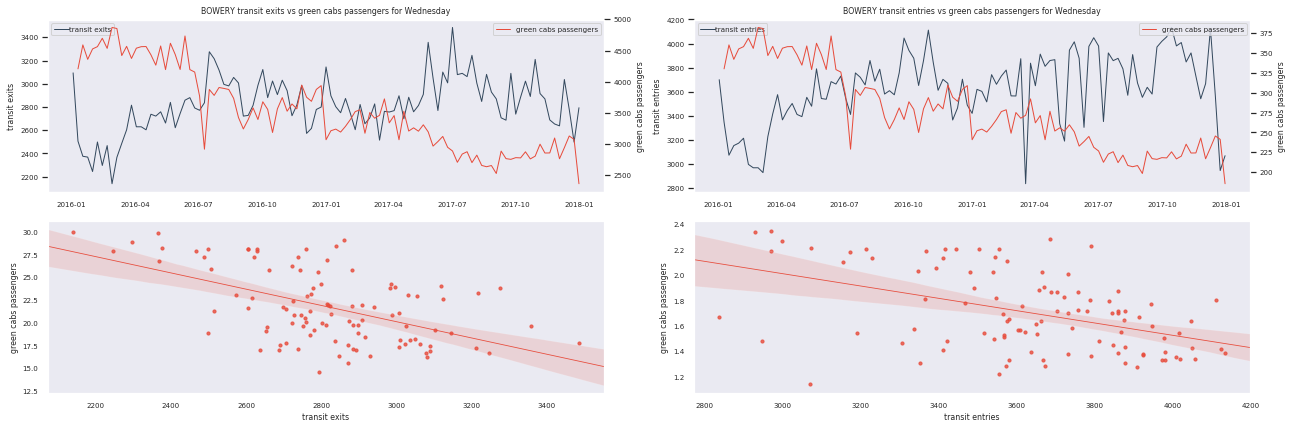

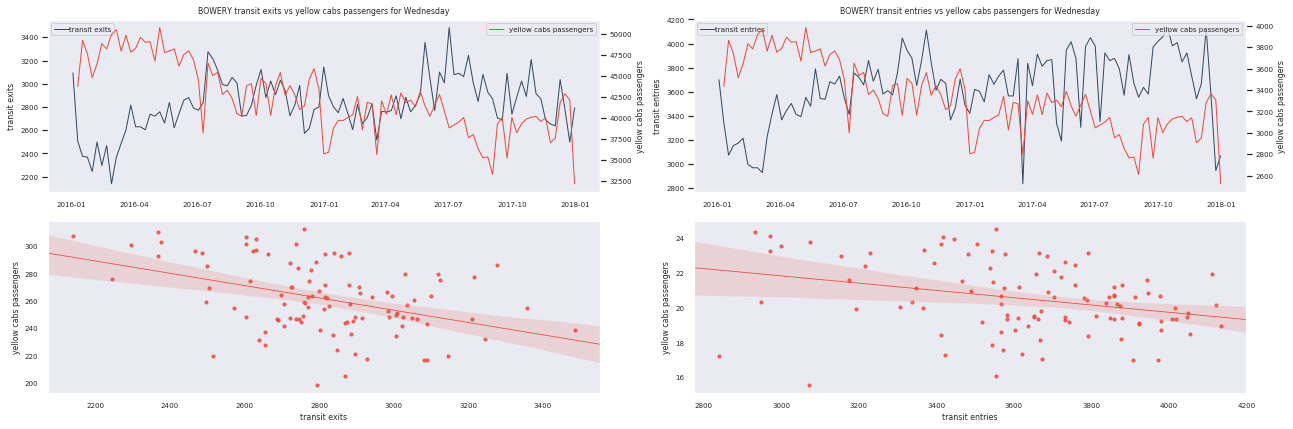

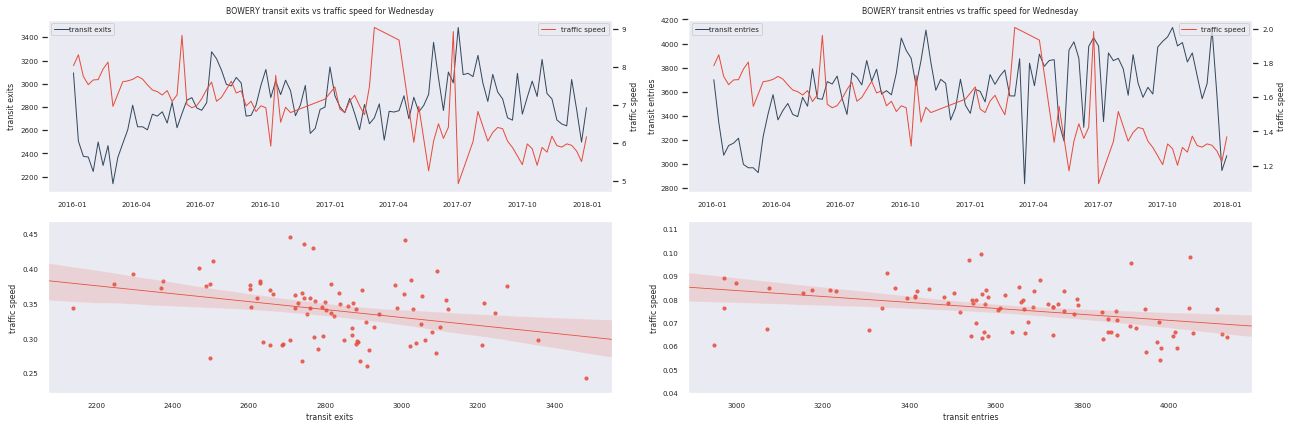

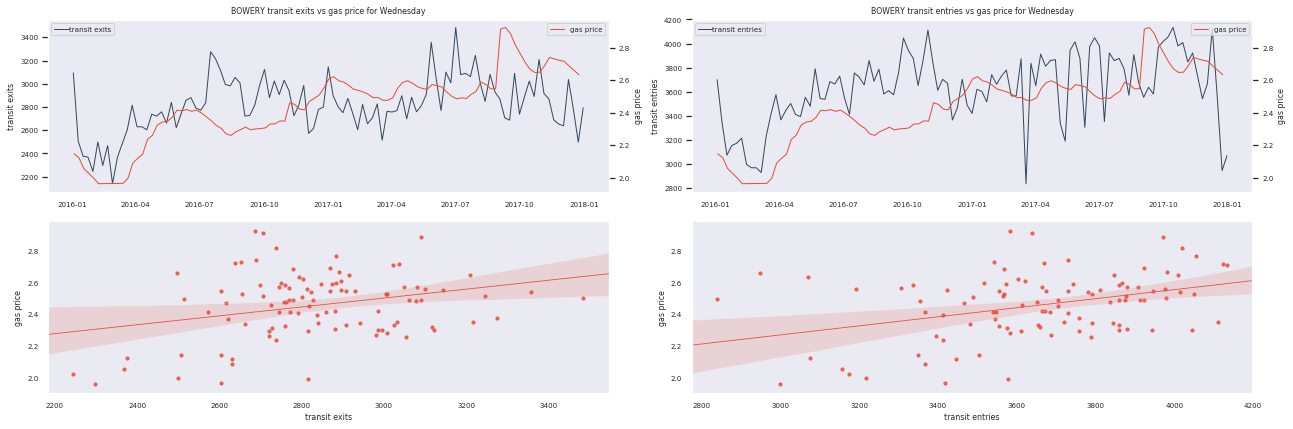

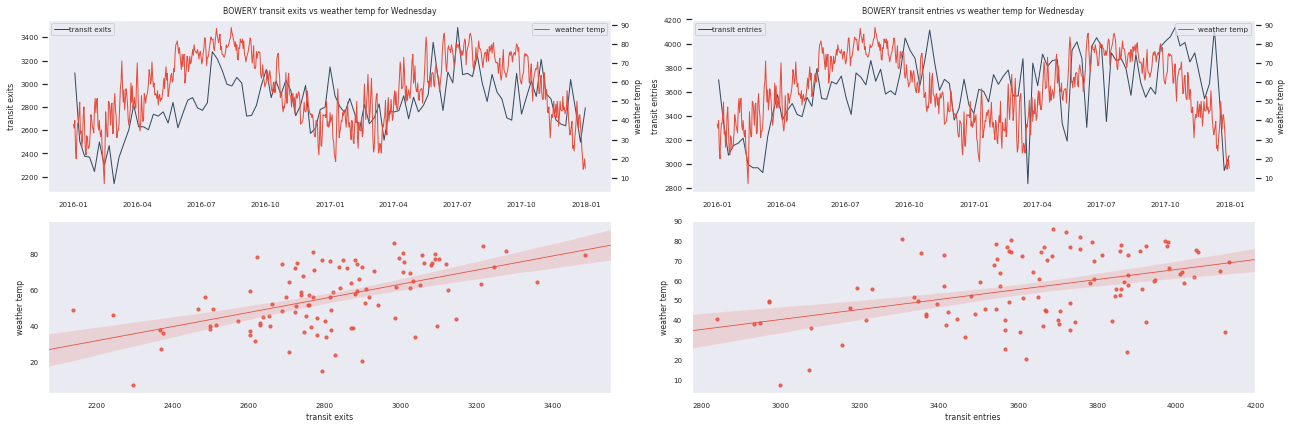

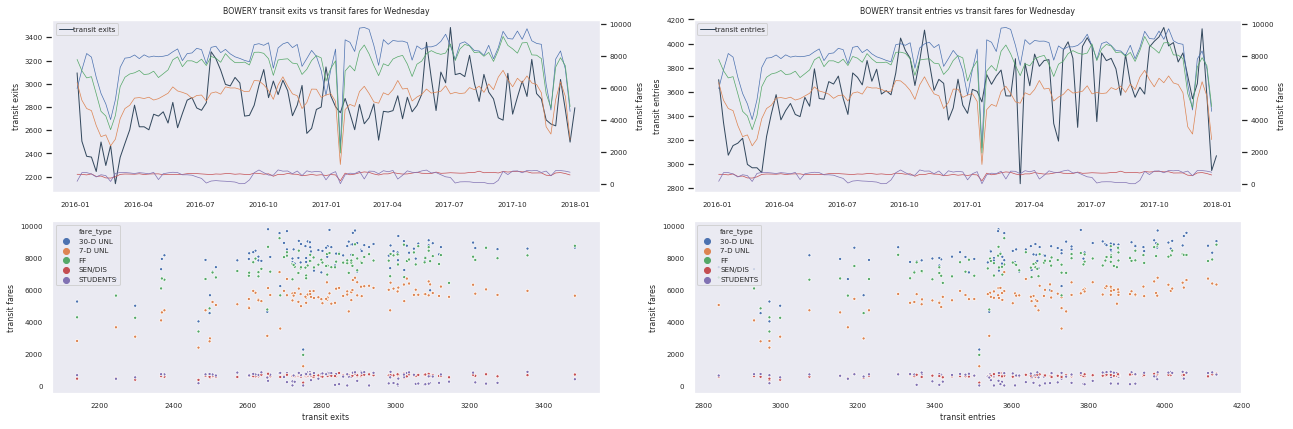

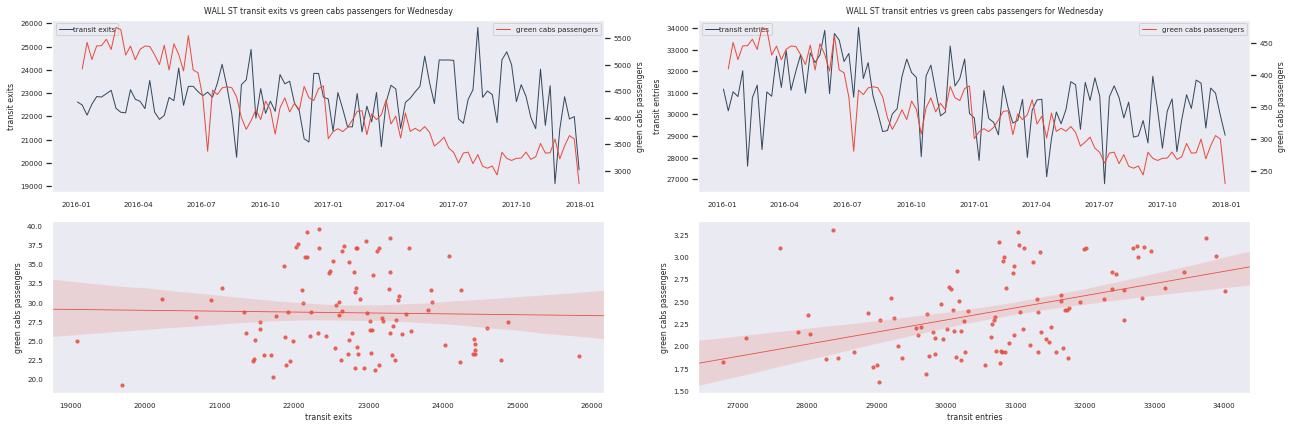

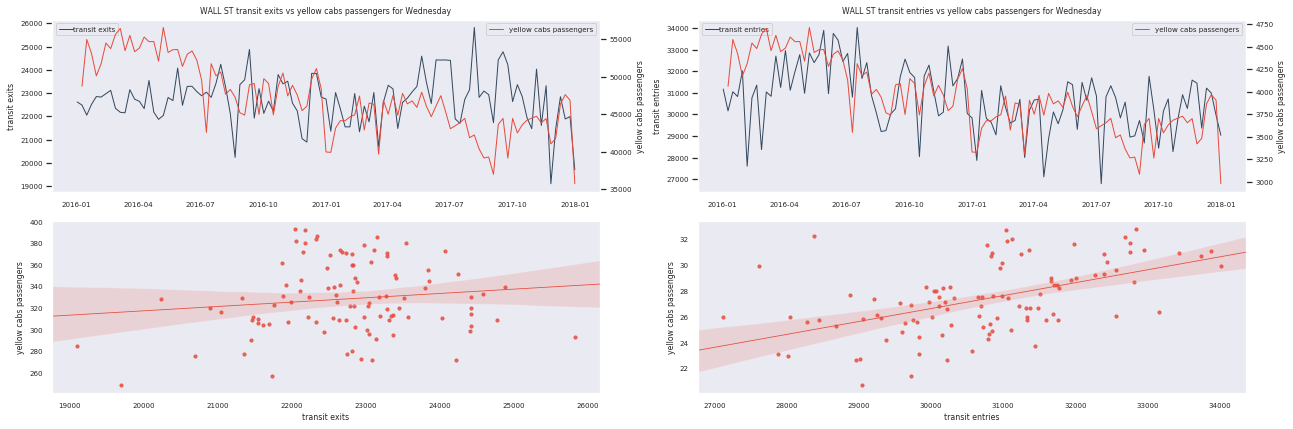

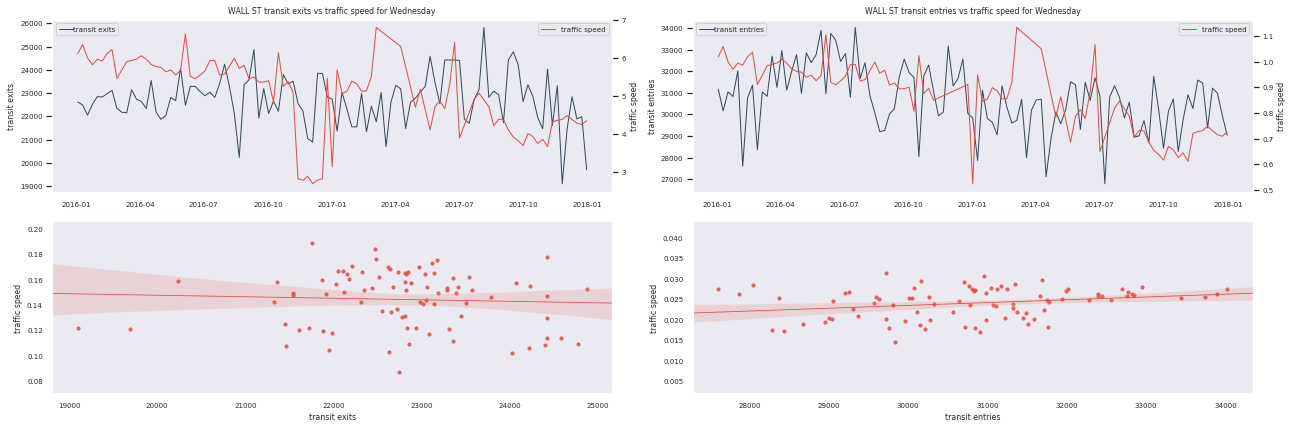

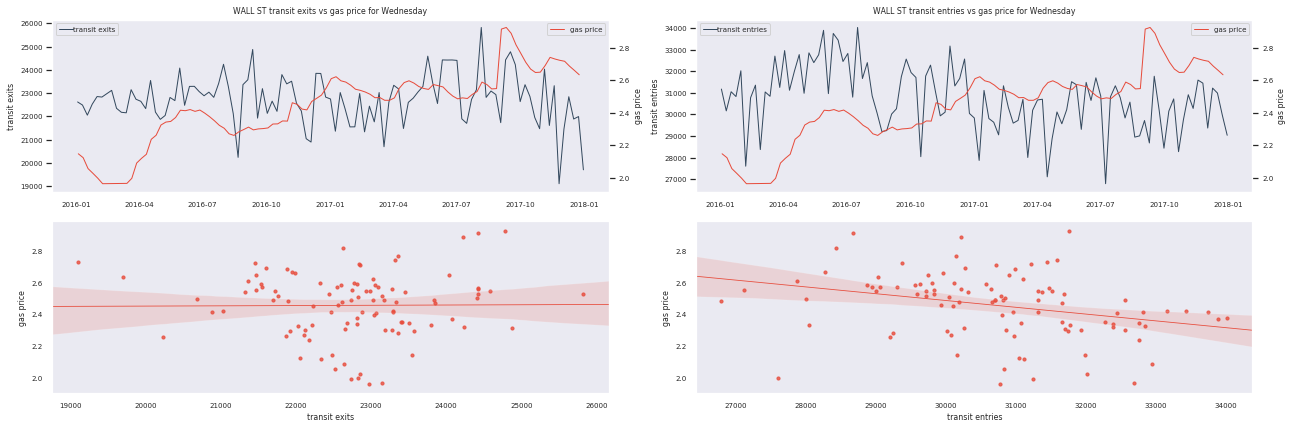

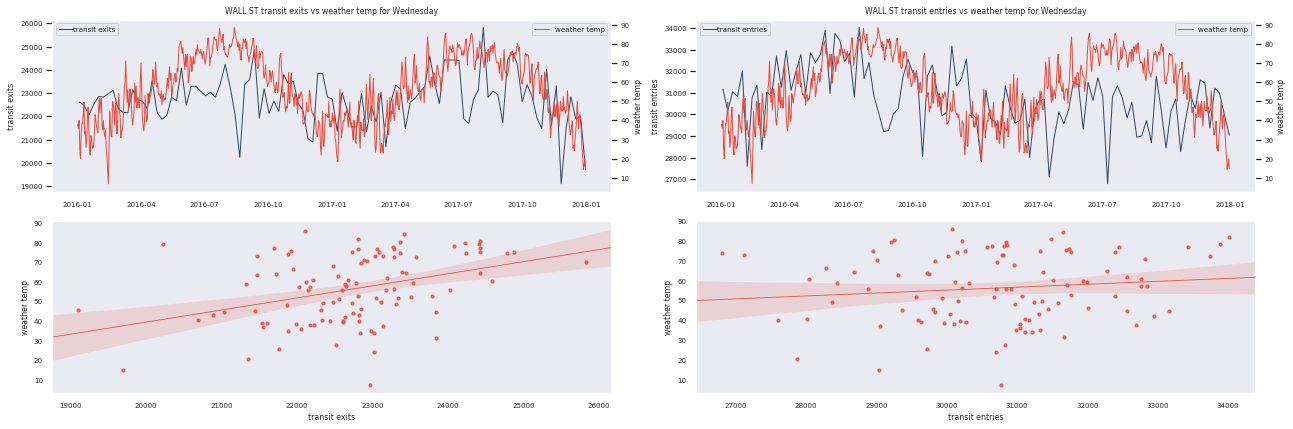

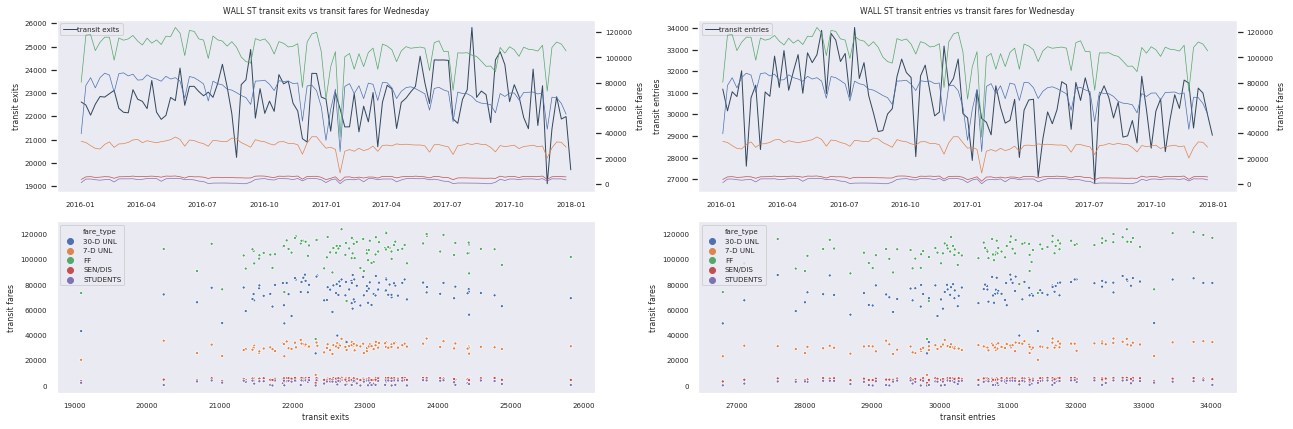

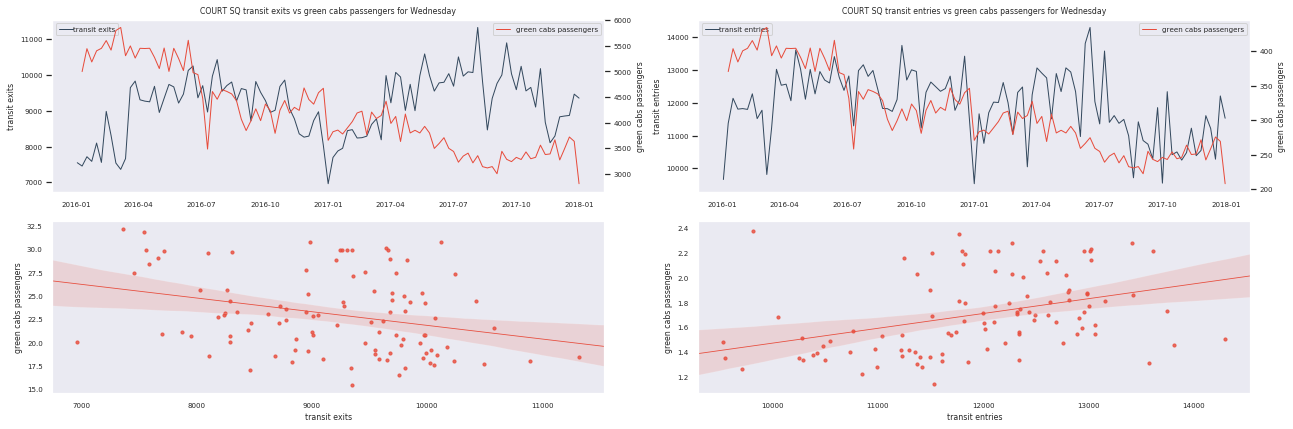

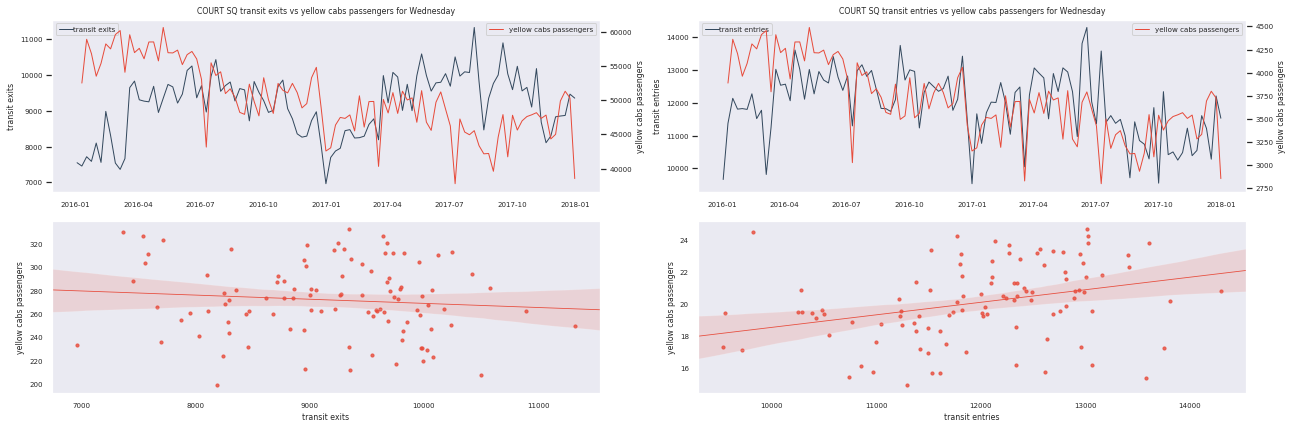

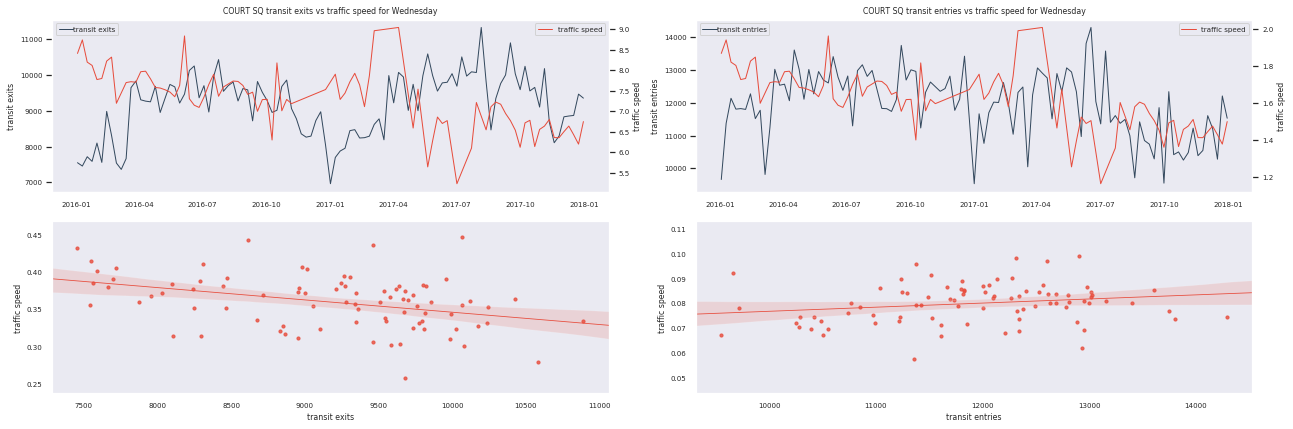

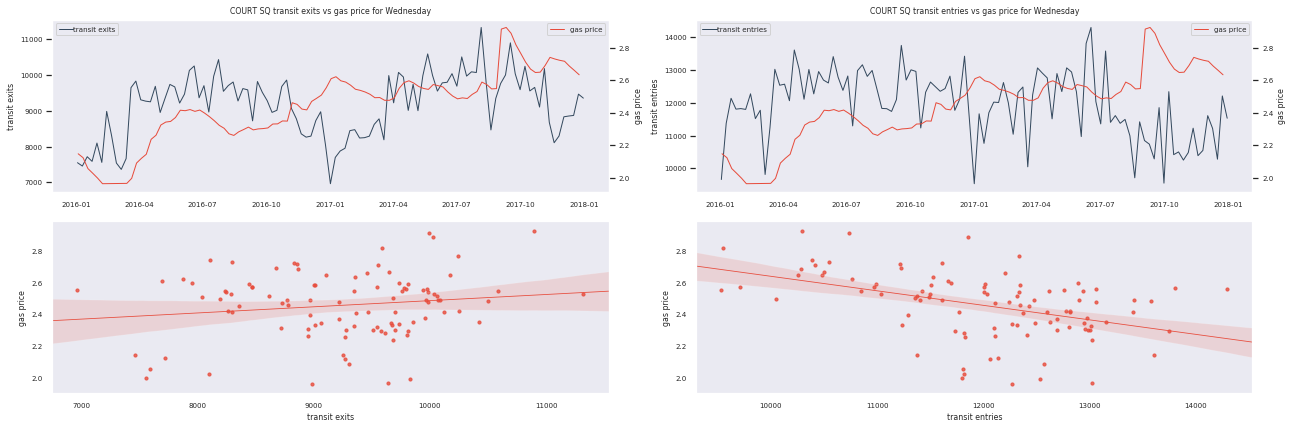

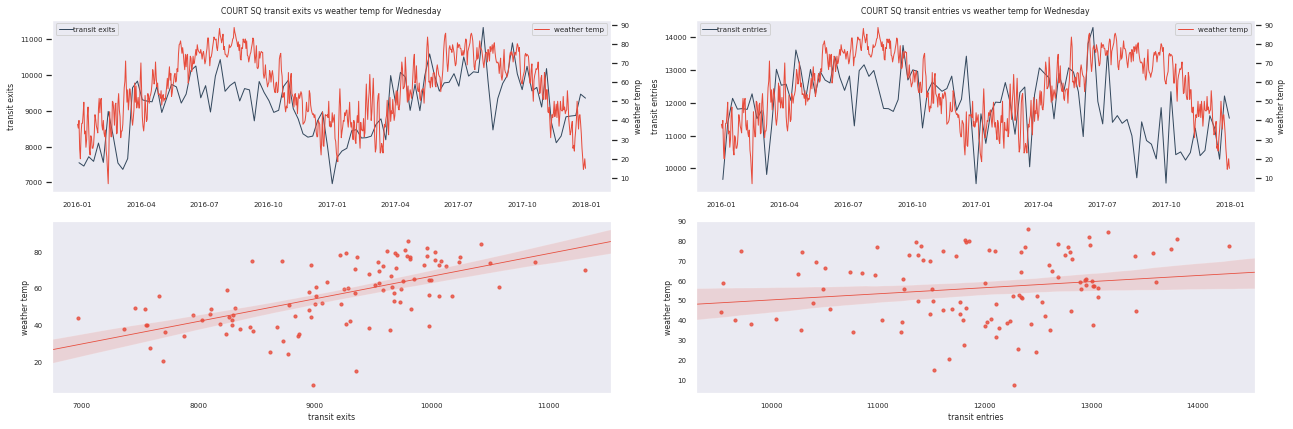

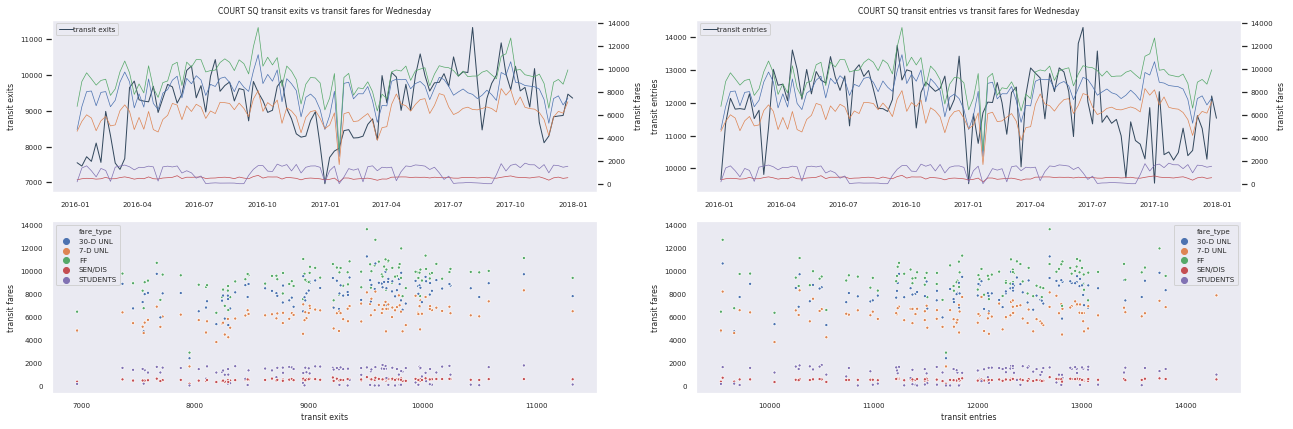

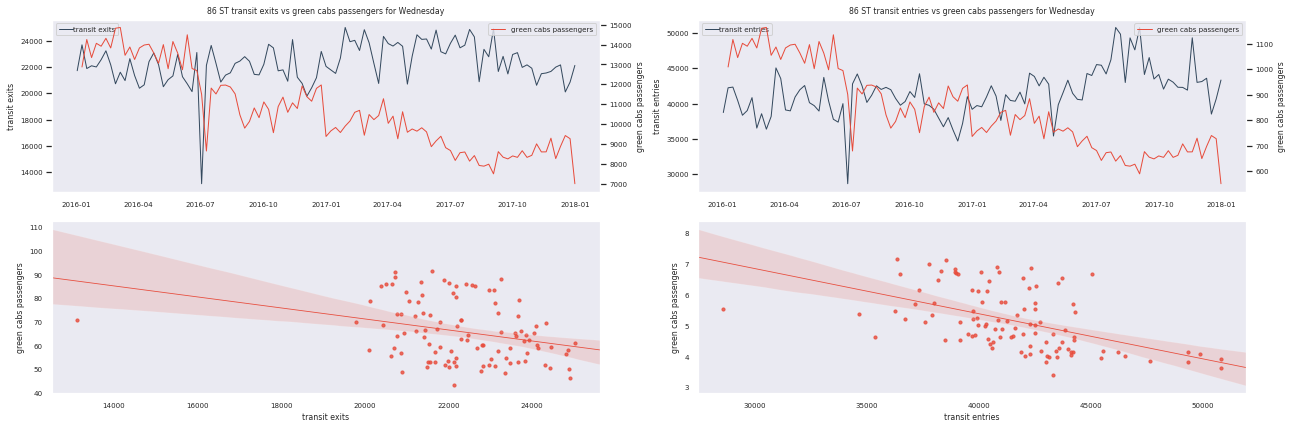

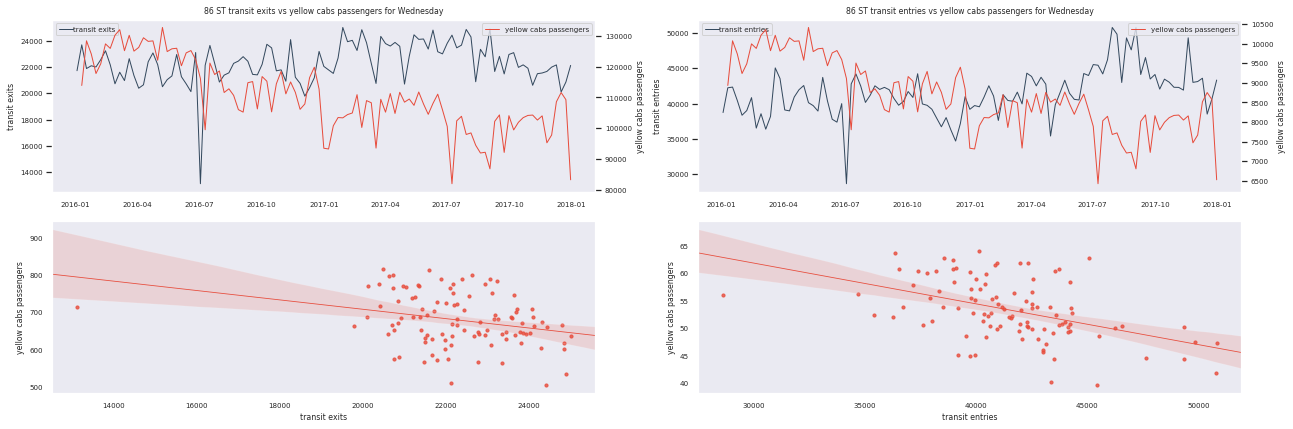

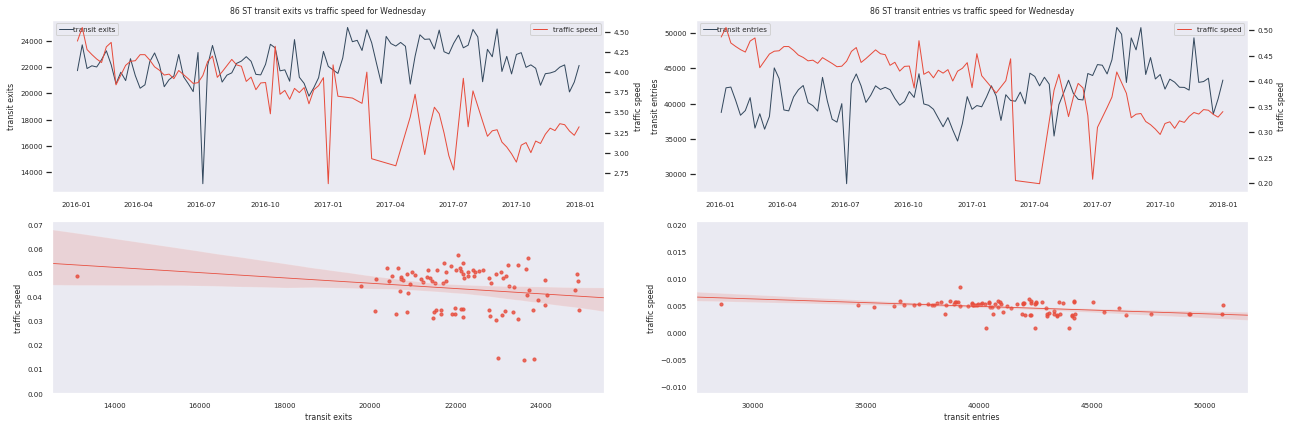

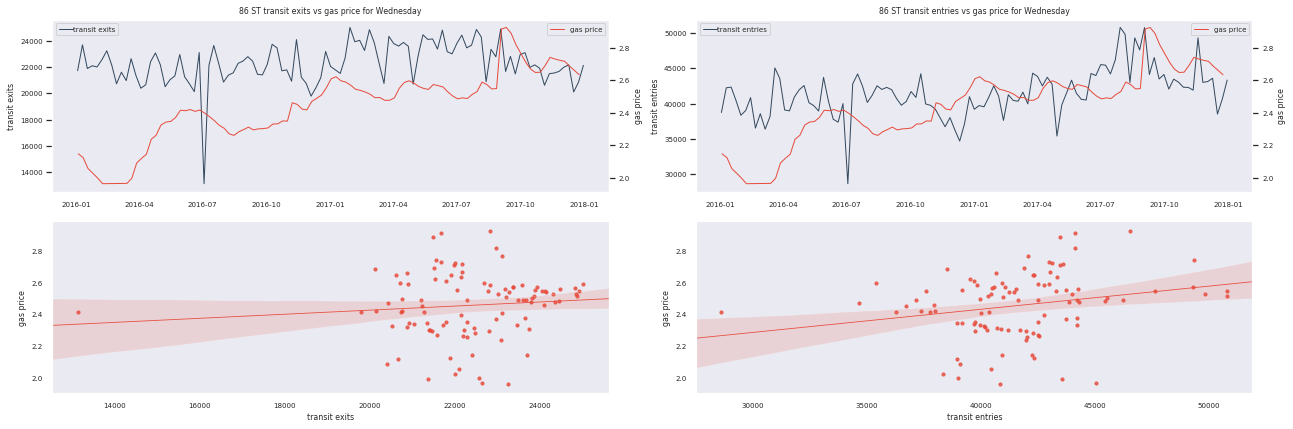

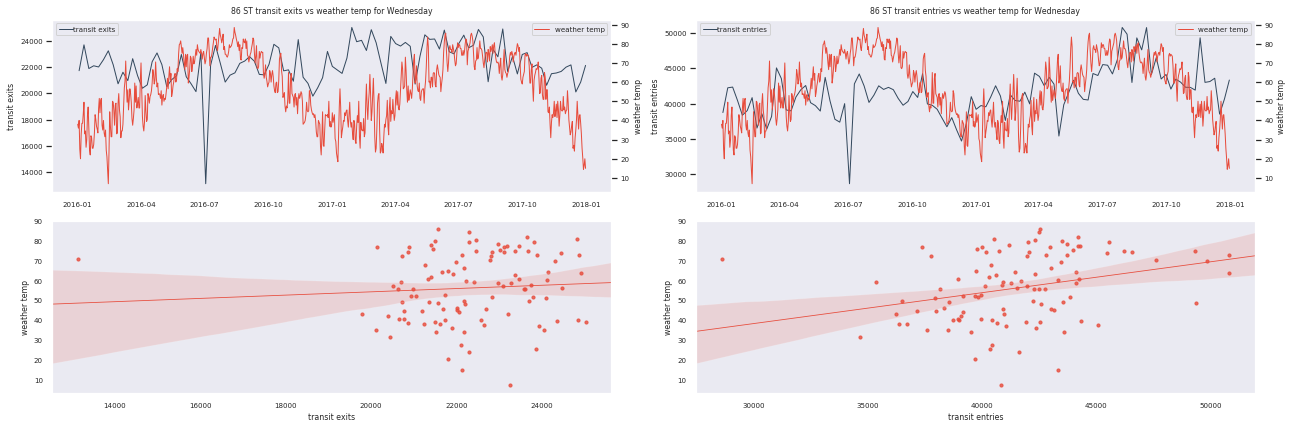

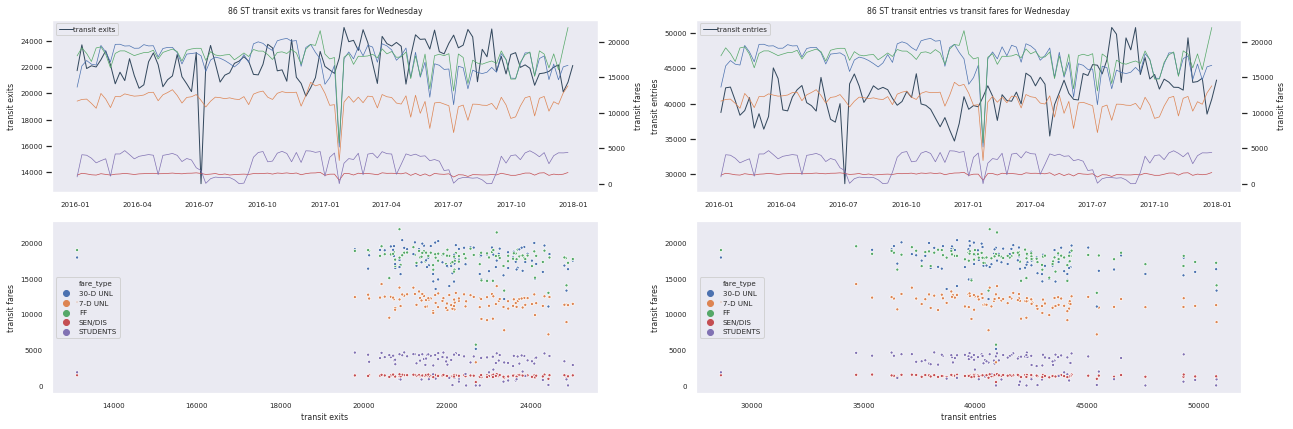

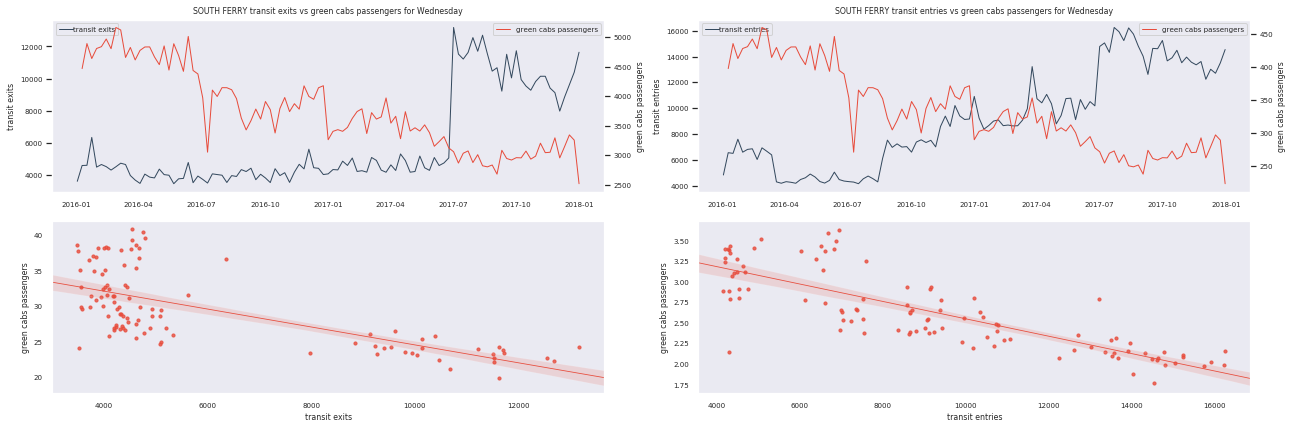

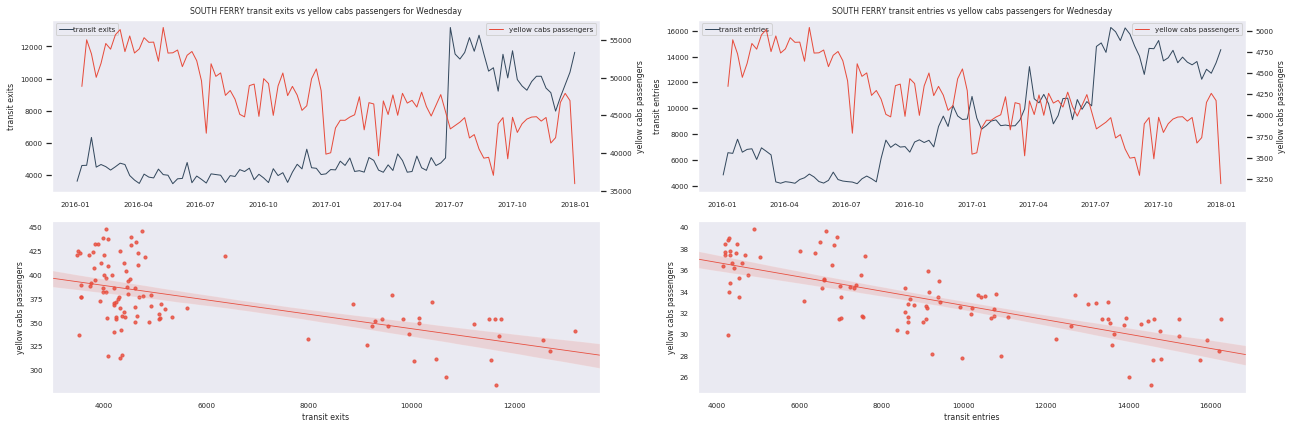

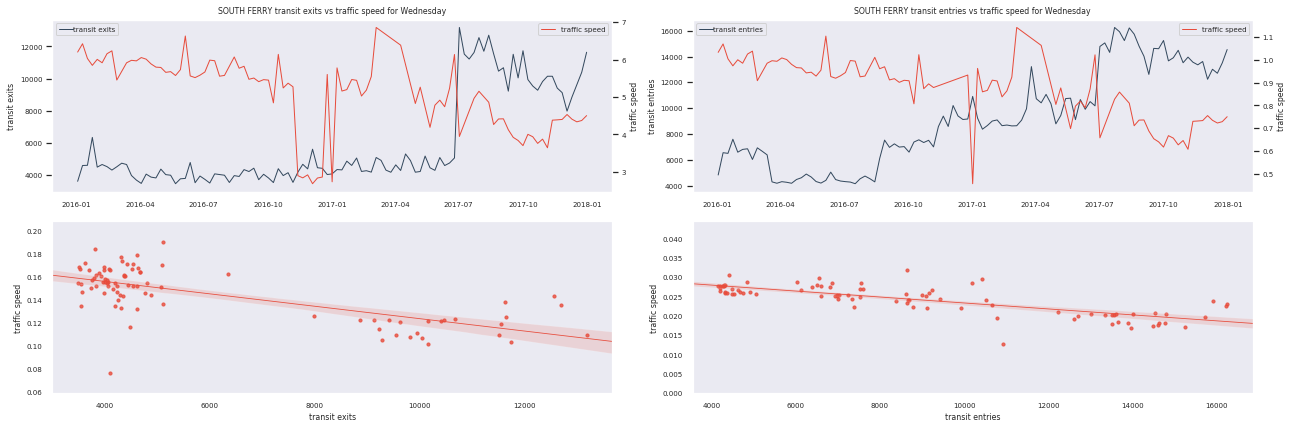

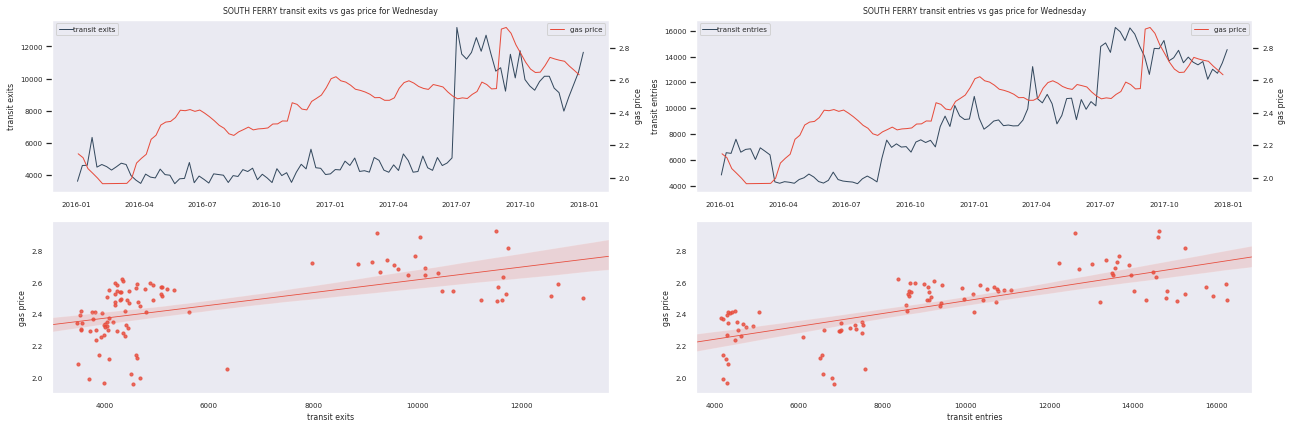

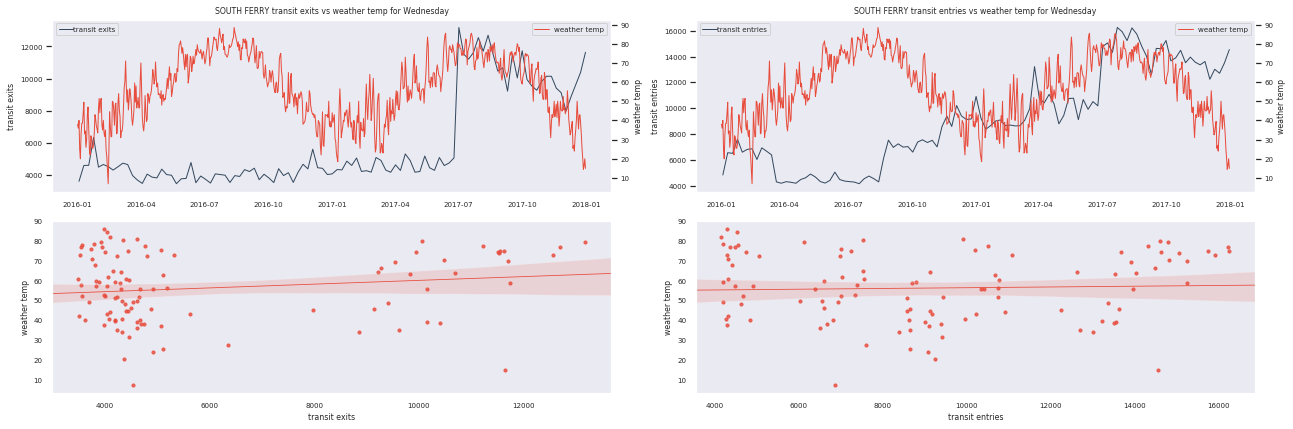

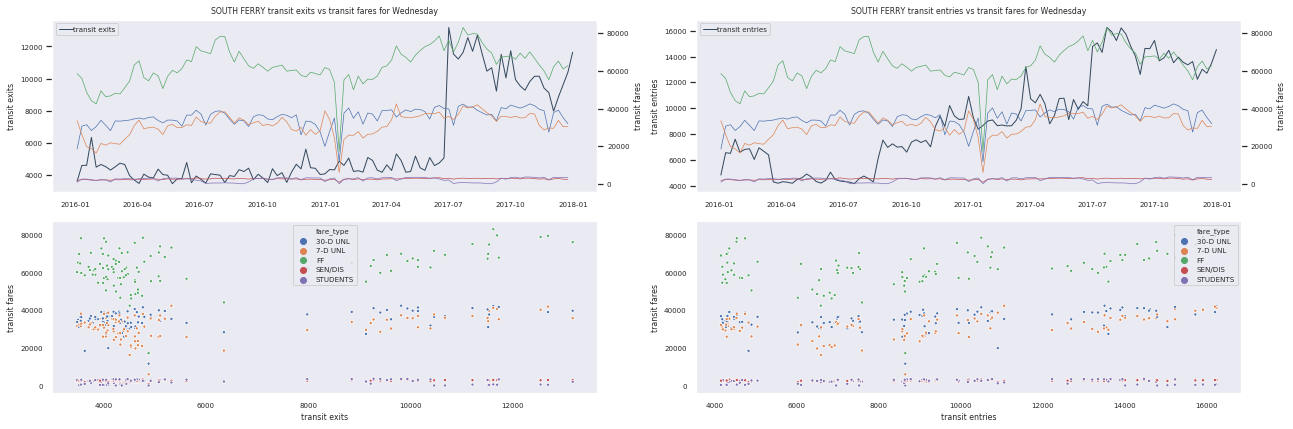

True

In [24]:
plot(['pl-1W-16-17', '1W', 'weekday', '2', 'BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY'])